## Understanding SSL usinig ECG data with VAE
### BMI-LAB (Seoul National University Hospital)

**self-supervised learning을 이해하기 위한 예제 - diffusion 기반의 모델로 pre-trained -> latent representation에 classifier 붙여서 이상 신호 탐지

<br>

- **Gyuyeon Lim (lky473736)**
- 2025.03.20.에 문서 작성
    
## <span id='dl'><mark>DL</mark></span>
    
self-supervised learning이란 unlabeled data를 이용하여 모델이 데이터를 잘 이해하기 위한 일종의 사전 작업이라고 볼 수 있다. 두 단계에 걸쳐서 작업을 수행하게 되는데, 이는 아래와 같다.

- stage 1 
    - (1) 모델이 unlabeled data를 이해하기 위해 문제를 새로히 정의한다. 
    - (2) 문제를 새롭게 정의하고 난 다음, 그 문제에서의 X, y를 새롭게 정의한다 (이때 y를 self-supervision이라고 함)
        - 이때 y는 자기 자신의 데이터 안에서 만든 label이다.
    - (3) 그 X와 y를 이용해서 모델을 학습시킨다
    - (4) 그 모델을 pre-trained model이라고 명명한다
    
- stage 2 
    - (1) stage 1에서 학습한 모델은 이미 데이터를 잘 표현할 수 있고 feature을 잘 추출할 수 있다. 그 모델을 불러온다
    - (2) pre-trained model 뒤에 main task에 걸맞는 layer를 추가한다
    - (3) fine-tuning하여 전체 모델을 재학습한다
    - (4) 실제 문제를 풀이한다 (이 실제 문제를 downstream task라고 부른다)
    
본 노트북에선 open dataset인 **MIT-BIH Arrhythmia Database에서의 ECG 신호를 이용하여 실험**을 진행한다. 

- stage 1
    - diffusion 모델을 이용하여 모델에 점진적인 노이즈를 주고, 그것을 다시 U-Net을 통해 원래 데이터로 복원한다.
    - 이 과정에서 모델은 데이터를 잘 이해할 수 있게 되면서, 이 모델은 pre-trained된다.
    - ECG 데이터를 잘 이해하는 기초 모델(Foundation Model)로서의 역할을 하게 된다.
    
- stage 2 
    - U-net에서 가운데 latent space에 해당되는 layer을 떼고, 그 뒤에 classifier를 붙여서 정상 vs 부정맥 분류 모델을 구축한다.

위 아이디어를 가지고 선행된 연구는 아래와 같다.

- **D3VAE [100]** → Diffusion 모델에서 Encoder의 Feature만 사용하여 Classification
- **ImDiffusion [101]** → Diffusion을 통해 Latent Representation을 추출하고, 이를 Anomaly Detection(이상 탐지) 모델에 적용

In [4]:
import numpy as np
import pandas as pd
import wfdb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

2025-03-20 11:00:39.162028: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


----

### data load and preprocessing

| **항목**               | **설명** |
|------------------------|---------|
| **출처**               | MIT (Massachusetts Institute of Technology) & Beth Israel Hospital (BIH) |
| **데이터 개수**         | 48명의 환자로부터 수집한 48개 레코드 |
| **신호 길이**          | 각 레코드는 약 30분 ECG 신호 포함 |
| **샘플링 속도**        | 360 Hz (1초당 360개 샘플) |
| **리드(Lead) 개수**    | 2개 (Lead I, Lead II) |
| **총 심박 수**        | 약 109,000개의 심장 박동(Heartbeat) |
| **어노테이션 (Annotations)** | 15가지 이상의 심장 박동 이벤트 및 부정맥 레이블 포함 |
| **파일 형식**         | `.dat` (ECG 신호), `.hea` (메타데이터), `.atr` (주석) |
| **주석 포함 내용**    | 정상 박동(N), 부정맥(LBBB, RBBB, PVC, APC 등) |

- "N' : Normal beat - 정상 심장 박동임
- "+" : Rhythm change - 리듬 변화 표시. 이건 심장의 박동이 아니라 리듬이 변화하는 곳을 의미
- "A" : Atrial premature beat - 심방조기수축임. 심장에서 발생하는 비정상적인 박동

본 실험에서는 결국 downstream task에서 "N"을 제외하는 모든 것을 0으로 두어 구성한다.

| 기호 | 의미 | 설명 |
|------|------|------|
| **N** | 정상 박동 (Normal beat) | 정상적인 심실 탈분극을 가진 심장 박동 |
| **/** | 심전도 리듬 변화 (Paced beat or rhythm change) | 리듬 변화가 발생한 지점 (페이스메이커 박동 포함 가능) |
| **f** | 심방세동 (Atrial fibrillation) | 심방이 불규칙적으로 수축하는 심방세동 상태 |
| **+** | 진단/코멘트 (Rhythm annotation) | 특정 리듬이나 이벤트에 대한 주석 |
| **~** | 신호 품질 문제 (Signal quality change) | 신호 품질이 저하되거나 노이즈 발생 가능성 |
| **A** | 심방 조기 박동 (Atrial premature beat, APC) | 심방이 정상보다 일찍 탈분극하는 경우 |
| **|** | 주석 마커 (Isolated marker) | 특정 분석을 위한 마커로 사용 |
| **V** | 심실 조기 박동 (Premature ventricular contraction, PVC) | 심실이 정상보다 먼저 탈분극하는 경우 |

In [5]:
def load_patient_data(record_id, sample_count=500000):
    try: 
        record = wfdb.rdrecord(f'mitdb/{record_id}', sampto=sample_count)
        annotation = wfdb.rdann(f'mitdb/{record_id}', 'atr', sampto=sample_count)
        
        ecgsignal = record.p_signal[:, 0] # lead 1만 사용함
        
        beat_labels = annotation.symbol
        beat_locations = annotation.sample
        
        return ecgsignal, beat_labels, beat_locations
    
    except :
        return None

patient_records = ['100', '101', '102'] # 100번, 101번, 102번 피험자
all_signals = []
all_labels = []
all_locations = []

for record_id in patient_records:
    signal, labels, locations = load_patient_data(record_id)
    if signal is not None:
        patient_id = np.full(len(locations), record_id)
        
        all_signals.append(signal)
        all_labels.extend(labels)
        
        offset = sum(len(s) for s in all_signals[:-1])
        all_locations.extend([loc + offset for loc in locations])
        
        print (f"patient {record_id}: {len(signal)} sample, {len(labels)} labels")

combined_signal = np.concatenate(all_signals) # 각각의 환자 데이터를 나란히 연결함

scaler = MinMaxScaler()
normalized_signal = scaler.fit_transform(combined_signal.reshape(-1, 1)).flatten()

print (f"전체 데이터: {len(normalized_signal)} sample, {len(all_labels)} labels")
print (f"{pd.Series(all_labels).value_counts()}")

patient 100: 500000 sample, 1748 labels
patient 101: 500000 sample, 1455 labels
patient 102: 500000 sample, 1688 labels
전체 데이터: 1500000 sample, 4891 labels
N    3262
/    1553
f      30
A      27
+       7
~       4
|       4
Q       2
V       2
Name: count, dtype: int64


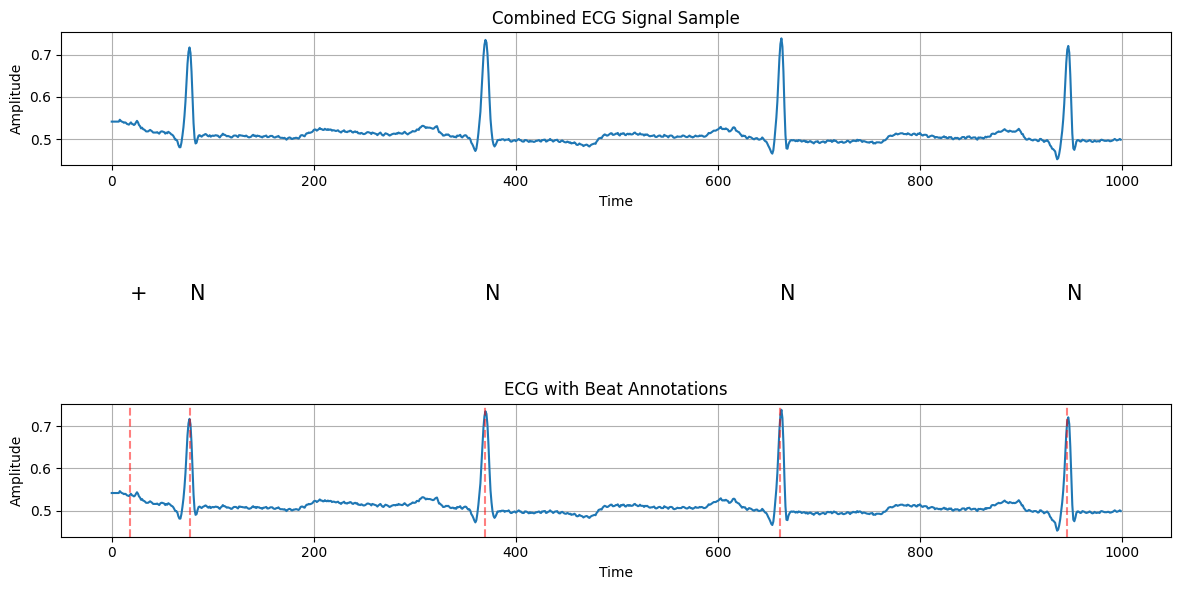

In [6]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(normalized_signal[:1000])
plt.title('Combined ECG Signal Sample')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(normalized_signal[:1000])
for i, loc in enumerate(all_locations):
    if loc < 1000:
        plt.axvline(x=loc, color='r', linestyle='--', alpha=0.5)
        plt.text(loc, 1.0, all_labels[i], fontsize=15)
plt.title('ECG with Beat Annotations')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

<img src="https://www.researchgate.net/publication/262384778/figure/fig1/AS:296912617000962@1447800892680/PQRST-complexes-in-the-ECG-waveform.png" width="400px">

ECG 데이터는 위 figure와 같이 구성되는데 이는 심장의 전기적 활동을 파형으로 나타낸 것이라 볼 수 있다. 애초에 Electrocardiogram이라는 이름을 축약하여 ECG라 명명하였기에, 심장박동의 일종의 전기적 신호를 측정한 검사라고 볼 수 있겠다. 각각의 element를 PQRST로 나눌 수 있는데, 각 요소가 의미하는 바는 아래와 같다.

- P : 심방이 탈분극하는 과정 (심방의 근육세포들이 전기자극 받아 수축한다)
    - 만약 P가 뚜렷하게 나타나지 않거나 없다면 -> 동방결절 증세가 의심
- PR interval : 심방에서 전기신호가 방실결절을 지나서 심실로 전달되는 시간
    - 정상범위는 200ms 내외
    - == P파 시작부터 QRS 시작까지의 시간
- QRS 
    - 심실이 탈분극하는 과정 (심실 수축과 연관이 있다)
    - 정상범위는 100ms
    - Q파 : 첫번째로 나타나는 음성파
        - 만약에 Q가 깊고 넓게 나타나게 된다면 심근경색이 의심됨
    - R파 : 가장 높은 양성파
    - S파 : R파 이후에 다시 하강하는 곳
- ST segment : 심실이 수축을 마침
    - 정상이면 평탄하거나 기준선과 거의 동일한 wave
    - 질환 의심
        - 만약에 ST가 상승한다면 : 급성 심근경색 의심
        - ST가 하강한다면 : 허혈성 심질환 의심
- T : 심실이 재분극하는 과정 
- QT interval : 심실의 전체 전기적 활동 (탈분극+재분극)에 걸리는 시간
    - 성인의 정상 범위가 약 0.36초 ~ 0.44초
- RR interval : 연속하는 두 개의 R파 사이의 시간
    - 심장은 주기적으로 뛰니, 당연히 특정 개형이 반복되는 형태일 것. 개형과 개형 사이의 element
    - 일종의 심박수, 만약 RR 간격이 60bpm보다 짧으면 서맥, 100bpm보다 높으면 빈맥
    - 평균은 약 80bpm인가봄

In [7]:
WINDOW_SIZE = 128 # <--- 원래 sampling rate가 360Hz이지만 구축하기 편하라고 128로 둠

def create_heartbeat_segments(signal, locations, labels, window_size):
    segments = []
    segment_labels = []
    
    for i, loc in enumerate(locations) : 
        start = max(0, loc - window_size // 2)
        end = min(len(signal), loc + window_size // 2)
        
        # Only use segments of exact window size
        if end - start == window_size: # <-- window size 맞춰줌 (항상 128로 일정하게)
            segment = signal[start:end]
            segments.append(segment)
            segment_labels.append(labels[i])
    
    return np.array(segments), segment_labels

segments, segment_labels = create_heartbeat_segments(normalized_signal, all_locations, all_labels, WINDOW_SIZE)

segments = segments[..., np.newaxis]
 
print (f"Number of heartbeat segments created: {len(segments)}")
print (f"Each segment shape: {segments.shape[1:]}")
print (f"Label distribution: {pd.Series(segment_labels).value_counts()}")

Number of heartbeat segments created: 4890
Each segment shape: (128, 1)
Label distribution: N    3262
/    1553
f      30
A      27
+       6
~       4
|       4
Q       2
V       2
Name: count, dtype: int64


In [8]:
binary_labels = np.array([1 if label != 'N' else 0 for label in segment_labels])
print (f"Binary label distribution - Arrhythmia ratio: {np.mean(binary_labels):.2f}")
print (np.bincount(binary_labels))

Binary label distribution - Arrhythmia ratio: 0.33
[3262 1628]


In [9]:
def mask_signal(sequence, mask_ratio=0.2) : # <--- VAE를 위해서 마스킹
    mask = np.random.rand(*sequence.shape) > mask_ratio
    return sequence * mask

masked_segments = np.array([mask_signal(seq) for seq in segments])

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    masked_segments, binary_labels, test_size=0.2, random_state=42, stratify=binary_labels
)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Training data arrhythmia ratio: {np.mean(y_train):.2f}") # stratify
print(f"Validation data arrhythmia ratio: {np.mean(y_val):.2f}") # stratify

Training data shape: (3912, 128, 1)
Validation data shape: (978, 128, 1)
Training data arrhythmia ratio: 0.33
Validation data arrhythmia ratio: 0.33


----

### stage 1 : pre-training model that can find the representation features of data
- 지금 하고자 하는 방법은 **<Self-Supervised Learning for Time Series Analysis: Taxonomy, Progress, and Prospects>** paper에서 나온 방법 중 **Pre-trained Diffusion Model의 Latent Representation을 이용한 Classification** 이다. 

In [11]:
# PARAMETERS of diffusino

timesteps = 1000  # 전체 diffusion timesteps
beta_start = 0.0001  # 시작 노이즈 비율
beta_end = 0.02  # 끝 노이즈 비율
beta_schedule = np.linspace(beta_start, beta_end, timesteps)  # 선형 스케줄
alpha_schedule = 1 - beta_schedule
alpha_bar_schedule = np.cumprod(alpha_schedule)

In [12]:
def forward_diffusion(x_0, t) : # <--- forward process (노이즈를 더함)
    noise = tf.random.normal(shape=tf.shape(x_0))
    
    alpha_bar_t = tf.gather(alpha_bar_schedule, t)
    alpha_bar_t = tf.reshape(alpha_bar_t, (-1, 1, 1, 1))
    
    x_t = tf.sqrt(alpha_bar_t) * x_0 + tf.sqrt(1 - alpha_bar_t) * noise
    return x_t, noise

In [14]:
class TimeEmbedding(layers.Layer):
    def __init__(self, dim=128, **kwargs):
        super(TimeEmbedding, self).__init__(**kwargs)
        self.dim = dim
        self.dense = layers.Dense(dim)
    
    def call(self, t):
        half = self.dim // 2
        freqs = tf.exp(-tf.math.log(10000.0) * tf.range(0, half, dtype=tf.float32) / half)
        
        # 배치 차원을 고려하여 연산 수행
        t = tf.cast(t, dtype=tf.float32)
        freqs = tf.reshape(freqs, [1, -1])  # [1, half]
        t = tf.reshape(t, [-1, 1])  # [batch, 1]
        
        args = t * freqs  # [batch, half]
        embedding = tf.concat([tf.cos(args), tf.sin(args)], axis=-1)
        embedding = self.dense(embedding)
        return embedding

def upsample_block(x, filters, kernel_size=3):
    x = layers.UpSampling1D(2)(x)
    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    return x

def downsample_block(x, filters, kernel_size=3):
    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.MaxPooling1D(2)(x)
    return x

def residual_block(x, filters, kernel_size=3):
    input_x = x
    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    if input_x.shape[-1] != filters: # <--- 만약 채널수가 맞지않으면 1*1 conv로 크기맞춰주기
        input_x = layers.Conv1D(filters, 1, padding='same')(input_x)
    
    x = layers.add([x, input_x])
    x = layers.LeakyReLU(0.2)(x)
    return x

def build_unet(input_shape=(128, 1), time_dim=128, base_filters=32):
    inputs = layers.Input(shape=input_shape)
    time_input = layers.Input(shape=(1,))
    
    t_emb = TimeEmbedding(time_dim)(time_input)
    t_emb = layers.Dense(time_dim, activation='swish')(t_emb)
    t_emb = layers.Dense(time_dim, activation='swish')(t_emb)
    
    x = layers.Conv1D(base_filters, 7, padding='same')(inputs)
    
    skips = []
    n_filters = [base_filters, base_filters*2, base_filters*4, base_filters*8]
    
    for f in n_filters:
        x = residual_block(x, f)
        skips.append(x)
        x = downsample_block(x, f)
    
    x = residual_block(x, base_filters*16) # BOTTLENECK  (latent space)
    
    temb = layers.Dense(base_filters*16)(t_emb)
    temb = layers.Reshape((1, base_filters*16))(temb)
    temb = layers.UpSampling1D(x.shape[1])(temb)
    x = layers.add([x, temb])
    
    for f in reversed(n_filters):
        x = residual_block(x, f)
        x = upsample_block(x, f)
        x = layers.Concatenate()([x, skips.pop()])
    
    x = residual_block(x, base_filters)
    outputs = layers.Conv1D(input_shape[-1], 1, padding='same', activation=None)(x)
    
    unet = keras.Model([inputs, time_input], outputs)
    return unet

unet = build_unet(input_shape=(WINDOW_SIZE, 1), time_dim=128, base_filters=32)
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 32)   │        256 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 128, 32)   │      3,104 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 32)   │        128 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 32)   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 32)   │      3,104 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 32)   │        128 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 32)   │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 128, 32)   │          0 │ add[0][0]         │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 32)   │      3,104 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 32)   │        128 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 128, 32)   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 64, 32)    │          0 │ leaky_re_lu_2[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 64, 64)    │      6,208 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64, 64)    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 64, 64)    │     12,352 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 64, 64)    │      2,112 │ max_pooling1d[0]

 Total params: 3,547,105 (13.53 MB)

 Trainable params: 3,539,169 (13.50 MB)

 Non-trainable params: 7,936 (31.00 KB)

In [15]:
class DiffusionModel:
    def __init__(self, unet, timesteps=1000, beta_start=0.0001, beta_end=0.02):
        self.unet = unet
        self.timesteps = timesteps
        
        self.beta = np.linspace(beta_start, beta_end, timesteps) # noise scheduling
        self.alpha = 1 - self.beta
        self.alpha_bar = np.cumprod(self.alpha)
        
    def get_loss(self, x_0, t, noise=None):
        if noise is None:
            noise = tf.random.normal(shape=tf.shape(x_0))
        
        x_t, _ = forward_diffusion(x_0, t)
        
        predicted_noise = self.unet([x_t, t]) # <- noise prediction
        
        loss = tf.reduce_mean(tf.square(noise - predicted_noise))
        return loss
    
    def sample(self, batch_size, shape=(128, 1)):
        x_t = tf.random.normal((batch_size,) + shape) # 순수 노이즈 (정규분포에서 추출함)
        
        for t in tqdm(range(self.timesteps - 1, -1, -1)):
            time_tensor = tf.ones(batch_size, dtype=tf.int32) * t
            
            predicted_noise = self.unet([x_t, time_tensor])
            
            alpha_t = self.alpha[t]
            alpha_bar_t = self.alpha_bar[t]
            beta_t = self.beta[t]
            
            if t > 0:
                noise = tf.random.normal(shape=tf.shape(x_t))
            else:
                noise = 0
            
            x_t = (1 / tf.sqrt(alpha_t)) * (
                x_t - ((1 - alpha_t) / tf.sqrt(1 - alpha_bar_t)) * predicted_noise
            ) + tf.sqrt(beta_t) * noise
            
        return x_t
    
    def extract_middle_features(self, x, t):
        """
            이걸 통해서 middle features, 즉 latent representations를 추출할 예정임
        """
        x_t, _ = forward_diffusion(x, t)
        
        inputs = layers.Input(shape=(WINDOW_SIZE, 1))
        time_input = layers.Input(shape=(1,))
        t_emb = time_embedding(time_input, 128)
        t_emb = layers.Dense(128, activation='swish')(t_emb)
        t_emb = layers.Dense(128, activation='swish')(t_emb)
        
        x_enc = layers.Conv1D(32, 7, padding='same')(inputs)
        n_filters = [32, 64, 128, 256]
        
        for f in n_filters:
            x_enc = residual_block(x_enc, f)
            x_enc = downsample_block(x_enc, f)
        
        x_enc = residual_block(x_enc, 512)
        
        feature_extractor = keras.Model([inputs, time_input], x_enc) # <-- 
        
        for layer in self.unet.layers:
            if layer.name in [l.name for l in feature_extractor.layers]:
                feature_layer = feature_extractor.get_layer(layer.name) # <--- model의 가중치를 u-net과 공유
                feature_layer.set_weights(layer.get_weights())
        
        features = feature_extractor([x_t, t])
        return features

diffusion_model = DiffusionModel(unet)

In [16]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

In [17]:
@tf.function
def train_step(x_0, diffusion_model):
    batch_size = tf.shape(x_0)[0]
    t = tf.random.uniform(shape=(batch_size,), minval=0, maxval=diffusion_model.timesteps, dtype=tf.int32)
    noise = tf.random.normal(shape=tf.shape(x_0))
    
    with tf.GradientTape() as tape:
        loss = diffusion_model.get_loss(x_0, t, noise)
    
    gradients = tape.gradient(loss, diffusion_model.unet.trainable_variables)
    optimizer.apply_gradients(zip(gradients, diffusion_model.unet.trainable_variables))
    return loss

In [18]:
def train_diffusion_model(diffusion_model, X_train, epochs=20, batch_size=32):
    losses = []
    n_batches = len(X_train) // batch_size
    
    for epoch in range(epochs):
        epoch_losses = []
        
        # 데이터셋 섞기
        indices = np.random.permutation(len(X_train))
        X_shuffled = X_train[indices]
        
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            x_batch = X_shuffled[start_idx:end_idx]
            
            # 배치 학습
            loss = train_step(x_batch, diffusion_model)
            epoch_losses.append(loss.numpy())
            
            if i % 50 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {i+1}/{n_batches}, Loss: {loss.numpy():.6f}")
        
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} completed, Average Loss: {avg_loss:.6f}")
        
        # 샘플 생성하여 시각화 (학습 진행 확인용)
        if (epoch + 1) % 5 == 0 or epoch == 0:
            generated = diffusion_model.sample(batch_size=4)
            
            plt.figure(figsize=(15, 3))
            for i in range(4):
                plt.subplot(1, 4, i+1)
                plt.plot(generated[i, :, 0])
                plt.title(f"Generated Sample {i+1}")
                plt.ylim(0, 1)
            plt.tight_layout()
            plt.show()
    
    return losses

In [19]:
print("Starting Diffusion model training...")
losses = train_diffusion_model(diffusion_model, X_train, epochs=30, batch_size=32)

Starting Diffusion model training...


TypeError: in user code:

    File "/var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_37944/2114592463.py", line 8, in train_step  *
        loss = diffusion_model.get_loss(x_0, t, noise)
    File "/var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_37944/1483507452.py", line 14, in get_loss  *
        x_t, _ = forward_diffusion(x_0, t)
    File "/var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_37944/4110578186.py", line 7, in forward_diffusion  *
        x_t = tf.sqrt(alpha_bar_t) * x_0 + tf.sqrt(1 - alpha_bar_t) * noise

    TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type float64 of argument 'x'.


-----

### stage 2 : downstream task  
- stage 1에서 ECG 데이터에 대한 표현을 학습하였다면, encoder 뒤에 classifier를 붙여서 다시 같은 데이터셋으로 재학습을 진행한다
    - fine-tuning (with 더 낮은 learning rate와 함께)을 통하여 부정맥 vs 정상을 detection하는 모델을 구축한다. 